This is another approch to tackle the protein classification problem, this time using deep learning algorithms. The main idea here is to make use of pre-trained protein language model for amino acid embedding. 

I use the BERT-based protein language model which embeds an amino acid into a float vector of length 768, a model that achieves promising results in several tasks, as described in the article by Rao et al [\[1\]](https://arxiv.org/abs/1906.08230). Since it is Transformer-based, this model and similar have an attention mechanism and may contain richer information about a given amino acid and those to which it pays attention (Vig et al [\[2\]](https://arxiv.org/abs/2006.15222)). This will be interesting for the current study since such embedding allows to implicitly include some kind of positional information.

The embedding is done on amino acid level but not at the sequence level. In this study, I would like to test 3 ways of vectorising a sequence starting from the BERT-based protein language model embedding:
1. the sequence is represented by taking average of the amino acid vectors that compose it, hence is of the same length (768);
2. by passing the sequence into an LSTM model, the sequence can be represented by the last hidden state. The length of the sequence representation is then the hidden state dimension of the LSTM model, to be defined by the user;
3. similar to 2, but instead of LSTM, an 1D-CNN is used to capture information of the whole sequence, in this case the dimension of final representation vector will depend on the kernel size, the padding size and the stride.

The vector representation of the sequences are the input of a dense neural network that is trained predict to which family the protein belongs.

In [1]:
import sys
sys.path.append('./pkg')
from Models import *
from DataProcessingHelper import *

No GPU available, using the CPU instead.


In [2]:
import gc
import matplotlib.pyplot as plt

In [3]:
# read samples of train data
PATH_TO_TRAIN = '../data/train/'
train = read_datafiles(PATH_TO_TRAIN)

# read samples of dev data
PATH_TO_DEV = '../data/dev/'
dev = read_datafiles(PATH_TO_DEV)

# read samples of test data
PATH_TO_TEST = '../data/test/'
test = read_datafiles(PATH_TO_TEST)

In [4]:
# again like the "feature engineering" part, I only focus on the most populated classes
# composing more than a half of the training set and are mutual in the 3 sets of data

trainClasses = set(train.family_accession.unique())
devClasses = set(dev.family_accession.unique())
testClasses = set(test.family_accession.unique())
onlyTrain = trainClasses.difference(devClasses)
train = train.loc[~train.family_accession.isin(onlyTrain)]
# class occurence counts
countFreq = train.family_accession.value_counts()
cumsum = countFreq.values.cumsum()
cumsumN = cumsum / cumsum.max()

mostPopular = countFreq.index[:10]
#mostPopular = countFreq.index[:np.where(cumsumN>=0.5)[0][0]]
#print("%d classes represent more than a half of the training data." % len(mostPopular))

In [5]:
trainSub = train.loc[train.family_accession.isin(mostPopular)]
testSub = test.loc[test.family_accession.isin(mostPopular)]
devSub = dev.loc[dev.family_accession.isin(mostPopular)]

In [6]:
# save my poor 16G ram
del train, test, dev, trainClasses, testClasses, devClasses
_ = gc.collect()

In [7]:
# vectorisation
# - word lvl: OK by pBert
# - sequence lvl: 
#   1. simple mean (bench mark)
#   2. final hidden state of an LSTM
#   3. 1D Conv (if I have had more resources (time, teammates, machine)...)
# classification
#   input the vectorised sequence to a dense NN

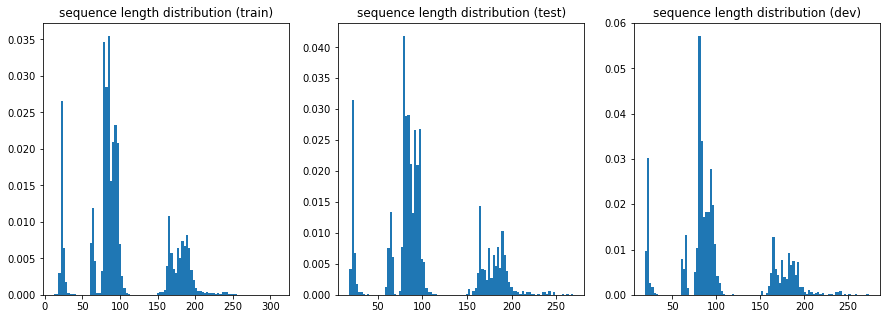

In [8]:
trainSeqLens = trainSub.sequence.apply(len)
testSeqLens = testSub.sequence.apply(len)
devSeqLens = devSub.sequence.apply(len)

fig,axes = plt.subplots(ncols=3,nrows=1,figsize=(15,5))
axes[0].hist(trainSeqLens, bins=100, density=True)
axes[0].set_title('sequence length distribution (train)')
axes[1].hist(testSeqLens, bins=100, density=True)
axes[1].set_title('sequence length distribution (test)')
axes[2].hist(devSeqLens, bins=100, density=True)
axes[2].set_title('sequence length distribution (dev)')
plt.show()

In [9]:
# for the rest of the study, I will constraint the sequence length to be 250
MAX_LEN = 250

In [10]:
# global vars / config
BATCH_SIZE = 32
NB_LABELS = trainSub.family_accession.nunique()
NB_EPOCHS = 3

NN_HIDDEN_SIZE = 100

### preparation for training models...

In [11]:
# numerise string labels
numLabelDict = {lab:i for i,lab in enumerate(trainSub.family_accession.unique())}

trainSub.insert(0,'label',value=trainSub.family_accession.apply(lambda x:numLabelDict[x]))
testSub.insert(0,'label',value=testSub.family_accession.apply(lambda x:numLabelDict[x]))
devSub.insert(0,'label',value=devSub.family_accession.apply(lambda x:numLabelDict[x]))

In [12]:
# convert other data types to torch.Tensor
trainLabels = torch.tensor(trainSub.label.values)
devLabels = torch.tensor(devSub.label.values)
testLabels = torch.tensor(testSub.label.values)

In [13]:
# prepare training data
trainTokensIdx = prepare_data(trainSub.sequence.values, maxLen=MAX_LEN)
trainData = create_data_loader(trainTokensIdx, trainLabels, batchSize=BATCH_SIZE)

In [14]:
# prepare test data
testTokensIdx = prepare_data(testSub.sequence.values, maxLen=MAX_LEN)
testData = create_data_loader(testTokensIdx, testLabels, batchSize=BATCH_SIZE)

## Deep learning models

### vectorise the sequence by taking mean of all words from bert embedding

In [ ]:
meanClassifier = MeanNNClassifier(nbLabels=NB_LABELS, nnHiddenSize=NN_HIDDEN_SIZE)
meanClassifier, optimizer, scheduler = initialize_classifier(meanClassifier,
                                                             batchSize=BATCH_SIZE,
                                                             epochs=NB_EPOCHS)

In [ ]:
train_model(meanClassifier, optimizer, scheduler, trainData, testData)

### represent the sequence by the last hidden state of an LSTM

In [15]:
lstmClassifier = LstmNNClassifier(nbLabels=NB_LABELS, nnHiddenSize=NN_HIDDEN_SIZE,
                                  lstmHiddenSize=500)
lstmClassifier, optimizer, scheduler = initialize_classifier(lstmClassifier,
                                                             batchSize=BATCH_SIZE,
                                                             epochs=NB_EPOCHS)

100%|██████████| 370264230/370264230 [00:47<00:00, 7803747.24B/s] 


In [16]:
train_model(lstmClassifier, optimizer, scheduler, trainData, testData)

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   10    |   2.300053   |     -      |     -     |  260.79  
   1    |   20    |   2.291721   |     -      |     -     |  241.51  
   1    |   30    |   2.291488   |     -      |     -     |  265.87  
   1    |   40    |   2.287117   |     -      |     -     |  596.98  
   1    |   50    |   2.288307   |     -      |     -     |  237.62  
   1    |   60    |   2.276187   |     -      |     -     |  240.20  
   1    |   70    |   2.283416   |     -      |     -     |  240.09  
   1    |   80    |   2.263982   |     -      |     -     |  236.07  
   1    |   90    |   2.262642   |     -      |     -     |  240.41  
   1    |   100   |   2.270820   |     -      |     -     |  239.50  
   1    |   110   |   2.280418   |     -      |     -     |  266.07  
   1    |   120   |   2.268796   |     -      |     -     |  236.83  


   3    |   10    |   2.283855   |     -      |     -     |  262.27  
   3    |   20    |   2.275361   |     -      |     -     |  239.39  
   3    |   30    |   2.273748   |     -      |     -     |  239.89  
   3    |   40    |   2.259929   |     -      |     -     |  238.97  
   3    |   50    |   2.272264   |     -      |     -     |  235.61  
   3    |   60    |   2.263865   |     -      |     -     |  242.23  
   3    |   70    |   2.263860   |     -      |     -     |  236.94  
   3    |   80    |   2.276695   |     -      |     -     |  238.28  
   3    |   90    |   2.279367   |     -      |     -     |  238.78  
   3    |   100   |   2.268514   |     -      |     -     |  236.32  
   3    |   110   |   2.272352   |     -      |     -     |  237.80  
   3    |   120   |   2.276473   |     -      |     -     |  239.19  
   3    |   130   |   2.278408   |     -      |     -     |  239.81  
   3    |   140   |   2.263778   |     -      |     -     |  239.71  
   3    |   150   | 

KeyboardInterrupt: 

### represent the sequence by an 1D-CNN + Max pooling

In [ ]:
cnnClassifier = CnnNNClassifier(nbLabels=NB_LABELS, sequenceLen=MAX_LEN, nnHiddenSize=NN_HIDDEN_SIZE,
                                nbKernels=300, kernelSize=3)
cnnClassifier, optimizer, scheduler = initialize_classifier(cnnClassifier,
                                                            batchSize=BATCH_SIZE,
                                                            epochs=NB_EPOCHS)

In [ ]:
train_model(cnnClassifier, optimizer, scheduler, trainData, testData)

The main obstacle for me to complete the study is mainly the number of parametres to be learned compare to the data availability. Let's take a closer look at the first senario, where no parametres to be learned for sequence representation. To train a 1-hidden-layer dense neural network, whose input dimension is 768 and output dimension is about $O(1e5)$, or $O(1e3)$ if we add some constraints on class population. Suppose the hidden layer is of dimension of $O(1e3)$, that gives $768 \times 1000 + 1000 \times 1000 = O(1e6)$ trainable model parametres (Note that the training set in its totality contains "merely" about $1e6$ records). Not only it demands powerful computational capacity, but also huge amount of labeled training data to have the model be reasonably trained. Let alone the two remaining senarios where even more parametres are needed for the sequence representation. The huge liberty degree of the models can result training failures.